## Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

## Discipline

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

## Uncertain Space

In [4]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [5]:
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':100004.412,'n_pax':120.0,'area':109.205,'ar':14.528,'fuel_type':'kerosene','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)



In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline


In [7]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=100)

    INFO - 16:48:24: *** Start Sampling execution ***
    INFO - 16:48:24: Sampling
    INFO - 16:48:24:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 16:48:24:    MDO formulation: MDF
    INFO - 16:48:24: Running the algorithm OT_MONTE_CARLO:
    INFO - 16:48:24:      4%|▍         | 4/100 [00:00<00:04, 21.26 it/sec]

    INFO - 16:48:26:    100%|██████████| 100/100 [00:02<00:00, 47.85 it/sec]
    INFO - 16:48:26: *** End Sampling execution (time: 0:00:02.116468) ***


In [8]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [9]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)


{'fm': array([1.]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [10]:
r2.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.99931484]),
 'length': array([nan]),
 'mtom': array([0.99913399]),
 'span': array([1.]),
 'tofl': array([0.99913224]),
 'vapp': array([0.99910606]),
 'vz': array([0.99942436])}

In [11]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)


{'fm': array([3.68219321e-17]),
 'length': array([0.]),
 'mtom': array([5.63593253e-12]),
 'span': array([0.]),
 'tofl': array([7.87645516e-14]),
 'vapp': array([6.02915504e-15]),
 'vz': array([6.1534806e-16])}

In [12]:
rmse.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.00034361]),
 'length': array([0.]),
 'mtom': array([8.60637556]),
 'span': array([0.]),
 'tofl': array([0.49525862]),
 'vapp': array([0.00517117]),
 'vz': array([0.00223611])}

In [13]:
from matplotlib import pyplot as plt

from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [14]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00788825]),
 'cef': array([1.00629333]),
 'fm': array([0.50918795]),
 'length': array([32.]),
 'mtom': array([63512.65186885]),
 'sef': array([1.00791544]),
 'span': array([39.83127214]),
 'tofl': array([1921.40004914]),
 'vapp': array([66.66833433]),
 'vz': array([4.72191589])}

In [15]:
variance = statistics.compute_variance()
variance

{'aef': array([7.37077678e-05]),
 'cef': array([8.44338002e-05]),
 'fm': array([0.00017232]),
 'length': array([0.]),
 'mtom': array([85529.99534381]),
 'sef': array([7.1277677e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([282.65996246]),
 'vapp': array([0.02991358]),
 'vz': array([0.00868639])}

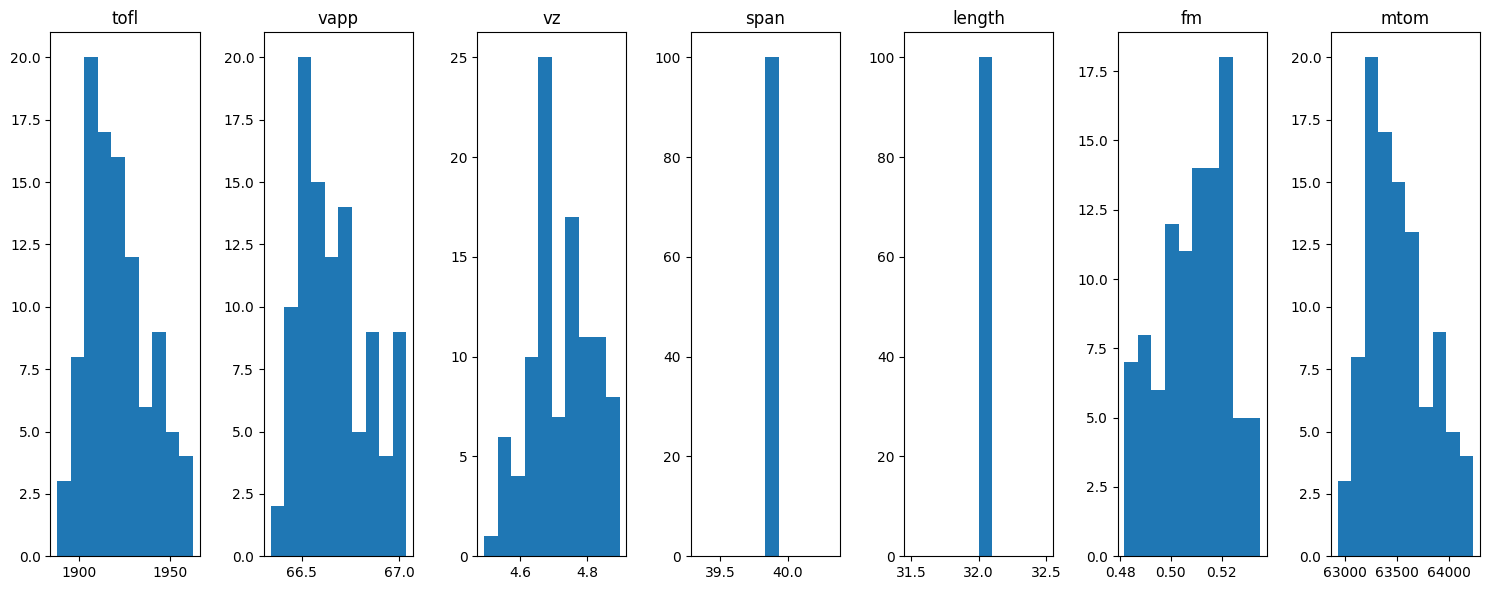

In [16]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [17]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [18]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 100)

 WARNING - 16:48:29: No coupling in MDA, switching chain_linearize to True.
    INFO - 16:48:29: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 16:48:29: SobolAnalysisSamplingPhase
    INFO - 16:48:29:    Disciplines: RBF_Sampling
    INFO - 16:48:29:    MDO formulation: MDF
    INFO - 16:48:30: Running the algorithm OT_SOBOL_INDICES:
    INFO - 16:48:31:    100%|██████████| 96/96 [00:01<00:00, 61.81 it/sec]
    INFO - 16:48:31: *** End SobolAnalysisSamplingPhase execution (time: 0:00:01.579634) ***


GROUP        inputs                       outputs                       \
VARIABLE        aef       cef       sef        fm length          mtom   
COMPONENT         0         0         0         0      0             0   
0          1.011287  1.018858  1.018127  0.489142   32.0  64015.410844   
1          0.996470  0.998531  0.994315  0.527076   32.0  62938.655266   
2          1.012159  1.000496  1.024286  0.514271   32.0  64020.247448   
3          0.999643  0.997105  0.997688  0.527627   32.0  63030.968433   
4          0.999603  1.028623  0.996241  0.485870   32.0  63333.940325   
..              ...       ...       ...       ...    ...           ...   
91         0.995934  0.999781  0.997909  0.526284   32.0  63051.395500   
92         1.016577  1.002006  1.006415  0.509035   32.0  63463.318399   
93         1.005482  0.997079  0.994671  0.523336   32.0  62964.524208   
94         1.021060  1.007666  1.003858  0.498150   32.0  63461.371936   
95         1.011845  1.020575  1.001509  0.486831   32.0  63471.050046   

GROUP                                                   
VARIABLE        span         tofl       vapp        vz  
COMPONENT          0            0          0         0  
0          39.831272  1950.353715  66.881345  4.577667  
1          39.831272  1888.538399  66.399724  4.927232  
2          39.831272  1950.627405  67.003853  4.572025  
3          39.831272  1893.802541  66.459149  4.888140  
4          39.831272  1911.121627  66.447090  4.810726  
..               ...          ...        ...       ...  
91         39.831272  1894.965773  66.465518  4.903043  
92         39.831272  1918.528856  66.638069  4.686061  
93         39.831272  1890.015958  66.398293  4.872642  
94         39.831272  1918.417093  66.585016  4.661307  
95         39.831272  1918.973682  66.536158  4.709948  

[96 rows x 10 columns]

In [19]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'aef': array([0.1625507]), 'cef': array([0.29651803]), 'sef': array([0.21193951])}], 'vapp': [{'aef': array([0.09795769]), 'cef': array([0.1086845]), 'sef': array([0.2647348])}], 'vz': [{'aef': array([0.43923216]), 'cef': array([0.40912835]), 'sef': array([0.10335348])}], 'fm': [{'aef': array([-0.22433558]), 'cef': array([0.99156695]), 'sef': array([-0.23803993])}], 'mtom': [{'aef': array([0.16293418]), 'cef': array([0.29774368]), 'sef': array([0.21323076])}]}, second={'tofl': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.35694614]]), 'sef': array([[-0.30590109]])}, 'cef': {'aef': array([[-0.35694614]]), 'cef': array([[0.]]), 'sef': array([[-0.40752651]])}, 'sef': {'aef': array([[-0.30590109]]), 'cef': array([[-0.40752651]]), 'sef': array([[0.]])}}], 'vapp': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.19491214]]), 'sef': array([[-0.19252469]])}, 'cef': {'aef': array([[-0.19491214]]), 'cef': array([[0.]]), 'sef': array([[-0.223

In [20]:
import pprint

In [21]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([-0.22433558]),
         'cef': array([0.99156695]),
         'sef': array([-0.23803993])}],
 'mtom': [{'aef': array([0.16293418]),
           'cef': array([0.29774368]),
           'sef': array([0.21323076])}],
 'tofl': [{'aef': array([0.1625507]),
           'cef': array([0.29651803]),
           'sef': array([0.21193951])}],
 'vapp': [{'aef': array([0.09795769]),
           'cef': array([0.1086845]),
           'sef': array([0.2647348])}],
 'vz': [{'aef': array([0.43923216]),
         'cef': array([0.40912835]),
         'sef': array([0.10335348])}]}
{'fm': [{'aef': array([0.09066279]),
         'cef': array([1.17960186]),
         'sef': array([0.01312107])}],
 'mtom': [{'aef': array([-0.02217454]),
           'cef': array([0.07184968]),
           'sef': array([0.79151281])}],
 'tofl': [{'aef': array([-0.02278423]),
           'cef': array([0.07158553]),
           'sef': array([0.79278495])}],
 'vapp': [{'aef': array([0.00811335]),
           'cef': array([0

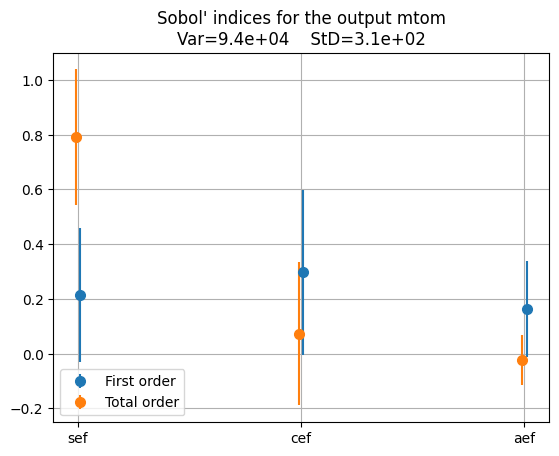

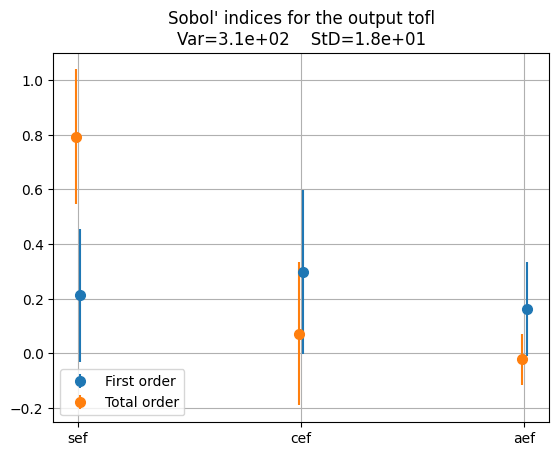

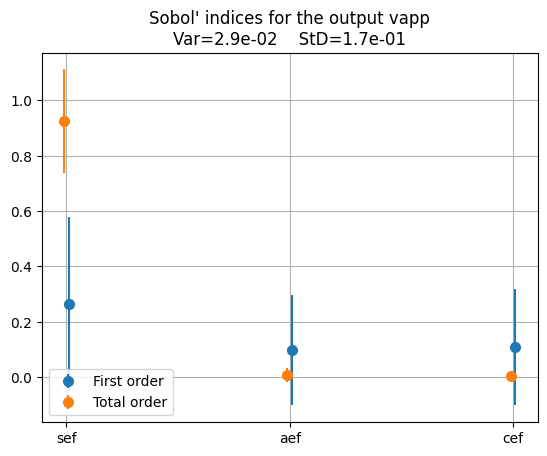

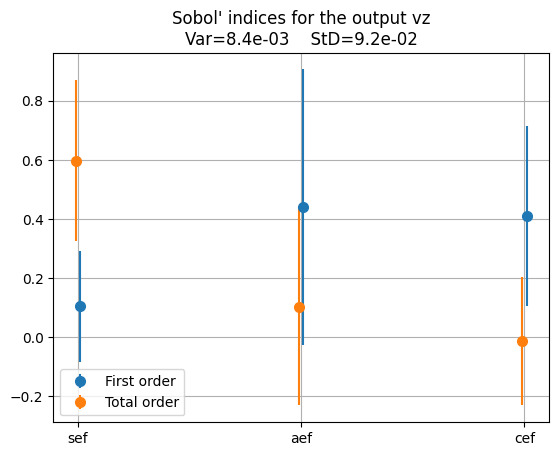

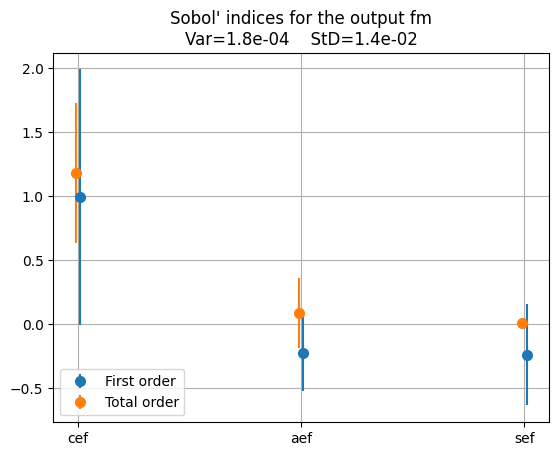

In [22]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))



